In [2]:
import pandas as pd
import glob
import re
import collections
import numpy as np
import matplotlib.pyplot as plt
from nltk.util import ngrams
from wordcloud import WordCloud
from IPython.display import display, HTML

First we need to combine all data files, since the data set is split among different files

In [38]:
df = pd.concat([pd.read_csv(f, delimiter='\t') for f in glob.glob('data/user-ct-test-collection-*.txt')])

c:\users\yusuf\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3249: DtypeWarning: Columns (0,3) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Next up, we randomly sample 1 million queries from the data set

In [ ]:
queries = df.sample(1000000, random_state=23)

Then, we create all possible suffixes by splitting the queries in words and iteratively removing the leading word, during this process, we normalize URLs by using a regex that detects the dots in URLs and replaces them by spaces.

In [ ]:
suffixes = []

for i, row in queries.iterrows():
    query = row['Query']
    if isinstance(query, str):
        line = re.sub(r"\.(.)", r" \1", query)
        queries.at[i, 'Query'] = line
        words = query.split()
        for j in range(0, len(words)):
            suffix = " ".join(words[j:])
            suffixes.append(suffix)

# np.save('pickles/historical_logs', suffixes)

Since this process takes quite a while, we store the results. We choose a hdf5 file since the array is very large and needs to be stored efficiently.

In [ ]:
with h5py.File('pickles/historical_logs.h5', 'w') as hf:
    hf.create_dataset("historical_logs",  data=suffixes)

If we already have a save-file, we can skip the steps performed before and start from this point on by reading the file in.

In [ ]:
with h5py.File('pickles/historical_logs.h5', 'r') as hf:
    suffixes = hf['historical_logs'][:]

We create a dictionary of all the candidates by using a counter from the collections library. We sort the values to analyze the top-n occuring candidates.

In [48]:
suffixes = np.load('pickles/suffix_candidates.npy')

historical_dict = collections.Counter(suffixes)
# historical_sorted = sorted(historical_dict, key=historical_dict.get, reverse=True)

The method below creates a dataframe ranking the top n-word suffixes in the historical logs.

In [35]:
def create_ranking(sorted_history, top_n=10, max_word_length=3):

    top_candidates = pd.DataFrame(index=range(1, top_n+1))
    
    indices = [1] * max_word_length
    
    for suffix in sorted_history:
        length = len(suffix.split())
        for i in range(1, max_word_length + 1):
            if length == i and indices[i-1] <= 10:
                top_candidates.at[indices[i-1], "Top "+str(i)+"-word suffixes"] = suffix
                indices[i-1] += 1
    return top_candidates

To demonstrate, below we create the top 5 n-word rankings for n = 1 to n = 5.

In [37]:
top_candidates = create_ranking(historical_sorted, top_n=5, max_word_length=5)
display(HTML(top_candidates.to_html()))

,Top 1-word suffixes,Top 2-word suffixes,Top 3-word suffixes,Top 4-word suffixes,Top 5-word suffixes
1,com,for sale,new york city,in new york city,keywords or web addresses here
2,lyrics,new york,in new york,or web addresses here,k nshop rgift thm s
3,.com,new jersey,chamber of commerce,in the united states,nshop rgift thm s&lid 256
4,florida,real estate,in new jersey,real estate for sale,nshop rgift thm s&lid 512
5,school,high school,homes for sale,in new york state,nshop rgift thm s&lid 2048
6,texas,north carolina,in north carolina,in san antonio texas,life of zack and cody
7,pictures,las vegas,federal credit union,long island new york,for sale in new york
8,sale,in florida,in las vegas,for sale by owner,restaurant in new york city
9,ny,los angeles,in los angeles,in san antonio tx,in atlantic city new jersey
10,ohio,school district,web addresses here,of the united states,in long island new york


We can also visualize the frequencies of the top n-word suffixes using word clouds. Below we visualize the top 20 4-word suffixes.

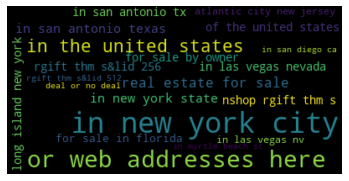

In [123]:
def gen_wordcloud(dictionary, amount_words, n=10):
    new_dict = {}
    for (key, value) in dictionary.items():
        if len(key.split()) == amount_words:
           new_dict[key] = value
    
    
    wordcloud = WordCloud(max_words=n).generate_from_frequencies(new_dict)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

gen_wordcloud(historical_dict, 4, 20)

The next features we need are the n-gram frequencies, as they are called in the paper. Below the method for the generation of these features is implemented.

In [104]:
def ngram_freq(candidate, historical_logs, n=6):
    words = candidate.split()
    ngram_features = []
    for i in range(1, n + 1):
        ngramfreq_i = 0
        ngrams_i = ngrams(words, i)
        for word in ngrams_i:
            freq_g = historical_logs[" ".join(word)]
            ngramfreq_i += freq_g
        ngram_features.append(ngramfreq_i)
    return ngram_features

An example of a candidate is "place to live in the greek islands for americans". Below we show the extraction of the ngram frequencies for up to 6-grams of this candidate. The number at index i is how often all of the (i+1)-grams occur in the historical logs

In [124]:
candidate = "place to live in the greek islands for americans"
ngramfeatures = ngram_freq(candidate, historical_dict, n=6)
ngramfeatures

[1564, 63, 11, 2, 2, 2]

In [ ]:
def get_other_features(candidate, historical_logs):
    features = []
    frequency = historical_logs[candidate]

'com'